In [1]:
import matplotlib.pyplot as plt
import torch
from lightning.pytorch import seed_everything
from monai.data.meta_obj import set_track_meta
from skimage.data import cells3d
from skimage.exposure import rescale_intensity
from torch.utils.benchmark import Measurement, Timer

from viscy.utils.blend import blend_channels

seed_everything(42)

img = rescale_intensity(cells3d(), out_range=(0, 1))

x = (
    torch.from_numpy(img)
    .permute(1, 0, 2, 3)
    .float()
    .to("cuda" if torch.cuda.is_available() else "cpu")
    .unsqueeze(0)
    .repeat(16, 1, 1, 1, 1)
)
print(x.shape)
print(x.device)

Seed set to 42


torch.Size([16, 2, 60, 256, 256])
cuda:0


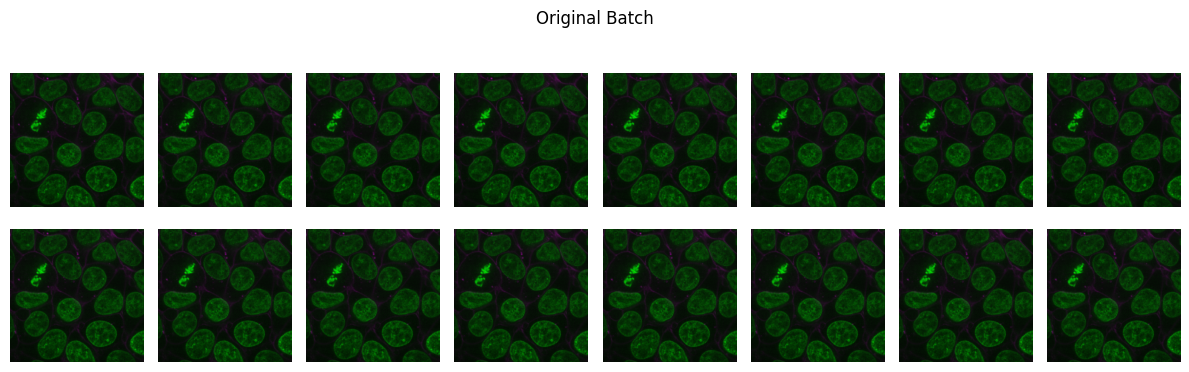

In [2]:
def plot_batch(batch: torch.Tensor, slice: int | None = None, title: str = ""):
    if slice is None:
        slice = batch.shape[2] // 2
    batch = batch[:, :, slice].detach().cpu().numpy()
    fig, axes = plt.subplots(2, batch.shape[0] // 2, figsize=(12, 4))
    for i, ax in enumerate(axes.flat):
        blended = blend_channels(batch[i], cmaps=["magenta", "green"], rescale=False)
        ax.imshow(blended, cmap="gray")
        ax.axis("off")
    fig.suptitle(title)
    fig.tight_layout()
plot_batch(x, title="Original Batch")

In [9]:
@torch.inference_mode()
def run_monai(x, monai_transform):
    set_track_meta(False)
    results = []
    for sample in x:
        cropped = monai_transform(sample)
        results.append(cropped)
    return torch.stack(results)


@torch.inference_mode()
def run_batched(x, batched_transform):
    return batched_transform(x)


def seconds_to_closest_unit(s: float) -> str:
    if s < 1e-6:
        return f"{s * 1e9:.2f} ns"
    elif s < 1e-3:
        return f"{s * 1e6:.2f} µs"
    elif s < 1:
        return f"{s * 1e3:.2f} ms"
    else:
        return f"{s:.2f} s"


def format_timer(measurement: Measurement) -> str:
    median = seconds_to_closest_unit(measurement.median)
    return f"{measurement.label}\n median={median}, n={measurement.number_per_run}"


def time_and_plot_transforms(x, monai_transform, batched_transform, n_iter: int = 5):
    monai_timer = Timer(
        label="MONAI",
        stmt="run_monai(x, monai_transform)",
        globals={"x": x, "monai_transform": monai_transform, "run_monai": run_monai},
    )
    batched_timer = Timer(
        label="Batched",
        stmt="run_batched(x, batched_transform)",
        globals={
            "x": x,
            "batched_transform": batched_transform,
            "run_batched": run_batched,
        },
    )
    monai_measurement = monai_timer.timeit(n_iter)
    plot_batch(run_monai(x, monai_transform), title=format_timer(monai_measurement))
    batched_measurement = batched_timer.timeit(n_iter)
    plot_batch(
        run_batched(x, batched_transform), title=format_timer(batched_measurement)
    )

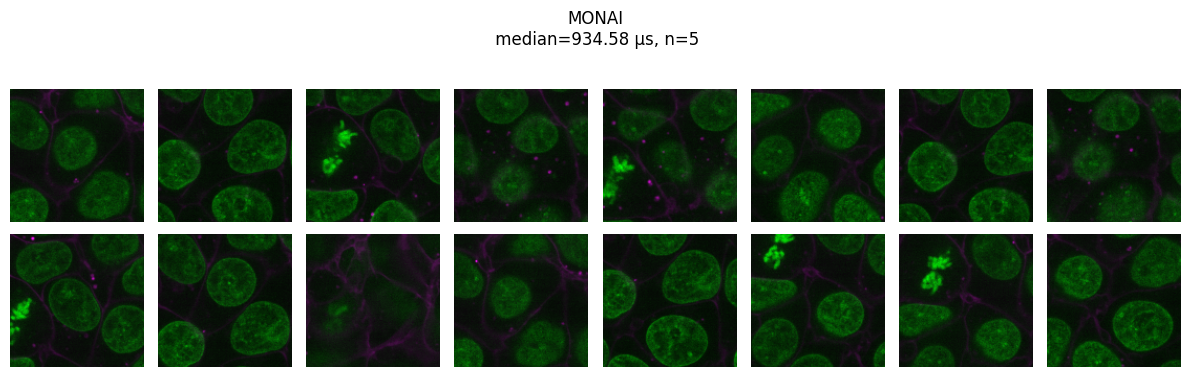

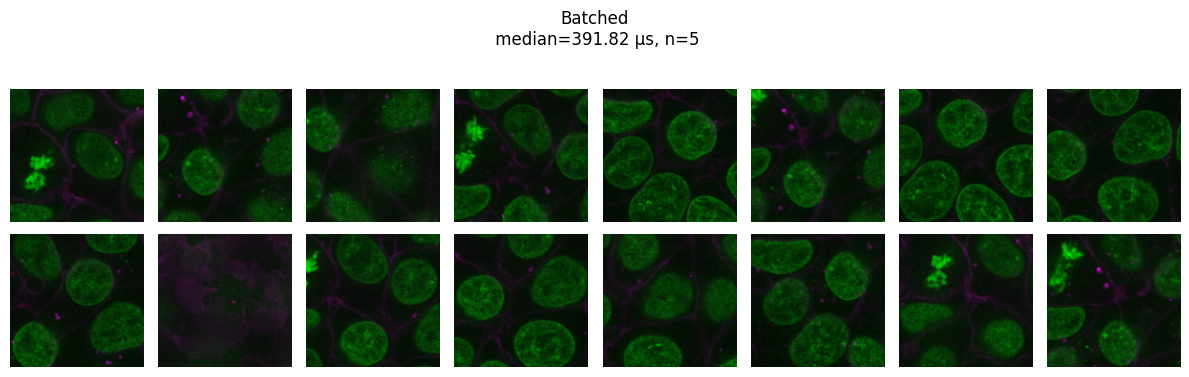

In [10]:
from monai.transforms import RandSpatialCrop

from viscy.transforms import BatchedRandSpatialCrop

rand_spatial_crop = RandSpatialCrop(roi_size=(32, 128, 128), random_center=True)
batched_rand_spatial_crop = BatchedRandSpatialCrop(roi_size=(32, 128, 128), random_center=True)

time_and_plot_transforms(x, rand_spatial_crop, batched_rand_spatial_crop)

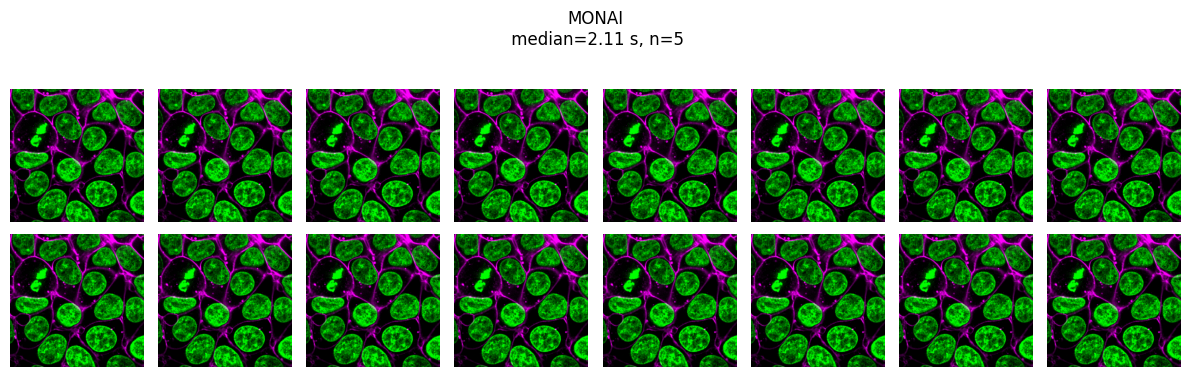

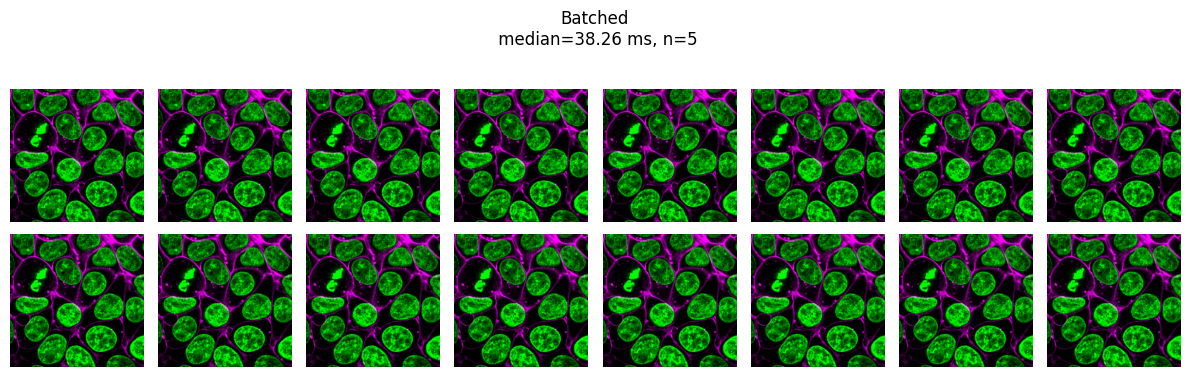

In [11]:
from monai.transforms import ScaleIntensityRangePercentiles

from viscy.transforms import BatchedScaleIntensityRangePercentiles

scale_intensity_range_percentiles = ScaleIntensityRangePercentiles(
    lower=50.0, upper=99.0, b_min=0.0, b_max=1.0, channel_wise=True
)
batched_scale_intensity_range_percentiles = BatchedScaleIntensityRangePercentiles(
    lower=50.0, upper=99.0, b_min=0.0, b_max=1.0, channel_wise=True
)

time_and_plot_transforms(
    x, scale_intensity_range_percentiles, batched_scale_intensity_range_percentiles
)

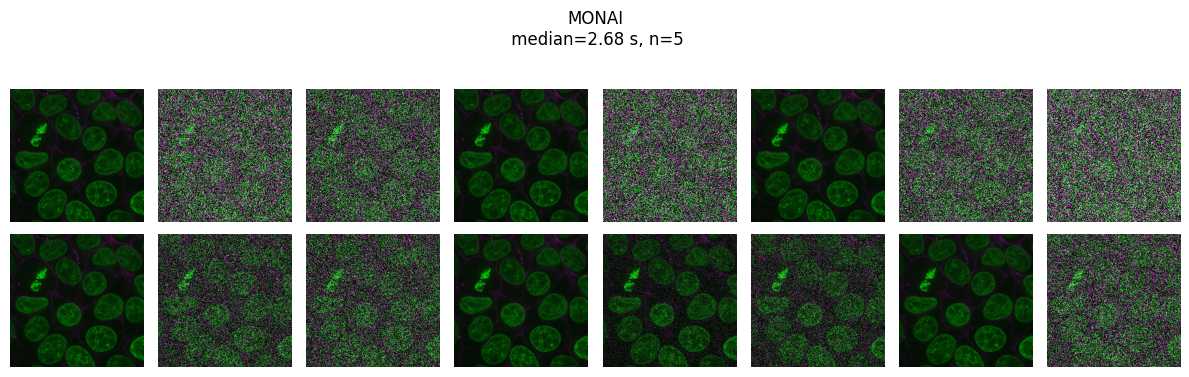

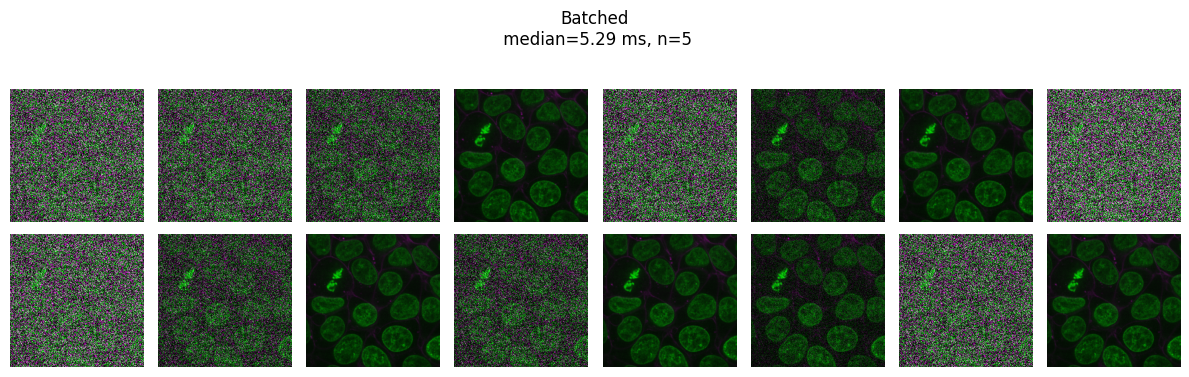

In [ ]:
from monai.transforms import RandGaussianNoise

from viscy.transforms import BatchedRandGaussianNoise

rand_gaussian_noise = RandGaussianNoise(prob=0.75, mean=0.0, std=1.0)
batched_rand_gaussian_noise = BatchedRandGaussianNoise(prob=0.75, mean=0.0, std=1.0)

time_and_plot_transforms(x, rand_gaussian_noise, batched_rand_gaussian_noise)